In [ ]:
'''
This notebook can help after creating a dataframe from the TAF forecast to plot hourly values from the groups.
Initially, Dataframe contains groups with start date and the end date. This function helps to visualize those groups hour by hour.
'''


In [2]:
#@title Functions TAf to Dataframe

''' I f you do not want to import functions and use this notebook separately,
run this cell containing functions to decode TAF to DF.
'''

import pandas as pd
import re
import datetime
import numpy as np

group_ind_re = r'\s(?P<group_ind>\d{1})\s'
Stdate_compl_pat = r'(\s{4}?P<year>\d{2})(?P<month>\d{2})(?P<day>\d{2})(?P<hour>\d{2})(?P<minute>\d{2})(\s)'
date_compl_pat = r'(?P<year>\d{4})(?P<month>\d{2})(?P<day>\d{2})(?P<hour>\d{2})(?P<minute>\d{2})(\s)'
timer_re = r'\s(?P<day>\d{2})(?P<hour>\d{2})(?P<minute>\d{2})Z\s'
group_timer_re = r'\s(?P<sday>\d{2})(?P<shour>\d{2})\/(?P<eday>\d{2})(?P<ehour>\d{2})\s'
#wind_pat =  r'\s(?P<dir>\d{3}|VRB)(?P<spd>\d{2})(?P<Gust>G\d{2})?(?P<unit>KT) (?:.+(\d{3})V(\d{3}))?'
wind_pat =  r'\s(?P<dir>\d{3}|VRB)(?P<spd>\d{2})(?P<Gust>G\d{2})?(?P<unit>KT)'
vis_pat = r'\s(?P<vis>\d{4})\s'
CAVOK_pat = r'(?P<cavok>CAVOK)'
AUTO_pat = r'(?P<auto>AUTO)'
phen_pat = r'\s(?P<int>(\-|\+|VC)*)?(?P<desc>(MI|PR|BC|DR|BL|SH|TS|FZ)*)?(?P<phen>(DZ|RA|SN|SG|IC|PL|GR|GS|UP|BR|FG|FU|VA|DU|SA|HZ|PY|PO|SQ|FC|SS|DS|NSW))'
cld_pat = r'(VV|NSC|NCD|BKN|SCT|FEW|OVC|///)(\d{3}|///)((TCU|CB|///|))\s'
# CLDs are handled by separate function - re is different!
temp_pat = r'(?P<temp>(M|\s)\d{2})\/(?P<dp_temp>(M|)\d{2})'
press_pat = r'(Q|A)(?P<press>\d{4})'

def adjust_Taf(Taf): # first adjustment of Taf - to identify separate groups, etc.
    '''replaces white spaces, replaces group indicators by numbers'''
    Taf = Taf.replace("\\n", " ")
    Taf = Taf.replace("\\r", " ")
    Taf = Taf.replace("PROB30 TEMPO", "PROB30TEMPO")
    Taf = Taf.replace("PROB40 TEMPO", "PROB40TEMPO")
    Taf = Taf.replace("=", " =")
    Taf = ' 0 ' + Taf
    for r in ((' PROB30TEMPO ', '= 3 '), (' PROB40TEMPO ', '= 5 '), (' TEMPO ', '= 1 '), (' PROB40 ', '= 4 '),
              (' PROB30 ', '= 2 '), (' FM', '= 7 '), ('BECMG', '= 6 ')):
        Taf = Taf.replace(*r)

    # create 1h BECMG instead of FM
    FM_pattern = '\s{1}7\s{1}\d{6}\s{1}'
    b = re.findall(FM_pattern, Taf)
    for item in b:
        Taf = Taf.replace(item, ' 6' + item[2:7] + '/' + item[3:7] + ' ')

    return Taf

def get_issue_date(metar):
  '''Retrieves datetime object of METAR report'''
  issue_dat_pat = r'(?P<year>\d{4})(?P<month>\d{2})(?P<day>\d{2})(?P<hour>\d{2})(?P<minute>\d{2})(\s)'
  try:
        a = re.search(issue_dat_pat, metar)
        return a.groupdict()
  except:
        return {
        'year': np.nan, 'month': np.nan,
        'day': np.nan, 'hour': np.nan,
        'minute': np.nan
    }


headdict_comp_pat = '.*(?P<Cdate>\d{12})\s.*(?P<taf_ind>TAF AMD|TAF COR|TAF)\s*(?P<station>\w{4})\s*(?P<day>\d{2})(?P<hour>\d{2})(?P<minute>\d{2})Z\s*((?P<sday>\d{2})(?P<shour>\d{2})\/(?P<eday>\d{2})(?P<ehour>\d{2})\s)'
headdict_short_pat = '.*(?P<taf_ind>TAF AMD|TAF COR|TAF)\s*(?P<station>\w{4})\s*(?P<day>\d{2})(?P<hour>\d{2})(?P<minute>\d{2})Z\s*((?P<sday>\d{2})(?P<shour>\d{2})\/(?P<eday>\d{2})(?P<ehour>\d{2})\s)'

def handle_heading(sampl_TAF):
    try:
        a = re.search(headdict_comp_pat, sampl_TAF)
    except:
        a = re.search(headdict_short_pat, sampl_TAF)

    heading_dic = a.groupdict() if a else {
        'Cdate': np.nan, 'taf_ind': np.nan,
        'station': np.nan, 'day': np.nan,
        'hour': np.nan, 'minute': np.nan,
        'sday': np.nan, 'shour': np.nan,
        'eday': np.nan, 'ehour': np.nan
    }
    return heading_dic

def create_groups_simply(Taf_adjusted):
    if " AMD " in Taf_adjusted: # if AMD in TAF, it must be known that there is AMD in all groups
        amd = " AMD "
    else:
        amd = ""
    compl_timer = re.search(date_compl_pat,Taf_adjusted).group()
    groups1 = re.split('=', Taf_adjusted)
    groups = [compl_timer + amd + ' ' + j for j in groups1 if len(j) >6]
    indics_Taf = []
    for group in groups:
        group_ind = re.search(' \d{1} ', group)
        if group_ind:
            indics_Taf = indics_Taf + [group_ind.group()]
        else:
            del group
    taf_grps = [i for i in groups if len(i)>6]
    return taf_grps


def cut_trend(metar_raw):
    '''TREND must be cut away in order to get raw METAR and extract items'''
    trend_ind = ['TEMPO', 'BECMG', ' FM ']
    metar = re.split('TEMPO |BECMG | FM', metar_raw)[0]
    return metar

def handle_wind(metar): # says metar but works also for TAF group
   a = re.search(wind_pat, metar)
   dic_a = {}
   if a:
      dic_a = a.groupdict()
   else:
      dic_a = {'dir': None, 'spd': None, 'Gust':None, 'unit': None}

   return dic_a

def handle_vis(metar): # says metar but works also for TAF group
  a = re.search(vis_pat,metar)
  b = re.search(CAVOK_pat,metar)
  if a:
    vis_dict = a.groupdict()
  elif b:
    vis_dict = {'vis': 9999}
  else:
    vis_dict = {'vis': None}
  return vis_dict

def handle_phen(metar):
  a = re.search(phen_pat, metar)
  dic_a = {}
  if a:
    dic_a = a.groupdict()
  else:
    dic_a = {'int': None, 'desc': None, 'phen': None}
  return dic_a

def handle_clouds(metar): # says metar but works also for TAF group
   a = re.findall(cld_pat, metar)
   b = re.search(CAVOK_pat,metar)
   if b:
    dic_a = {'cover': 'NSC','height': '','cloud':''}
   elif a:
    dic_a = {}
    l = len(a)
    for i in range(0,l):
        dic_i = {'cover'+ str(i): a[i][0], 'height'+str(i): a[i][1], 'type'+str(i): a[i][2]}
        dic_a = {**dic_a, **dic_i}
   else:
     dic_a = {'cover': None ,'height': None,'cloud': None}
   return dic_a

def handle_cld(metar):
   a = re.findall(cld_pat, metar)
   b = re.search(CAVOK_pat,metar)
   if b:
    dic_a = {'cover': 'NSC','height': '','cloud':''}
   elif a:
    dic_a = {}
    l = len(a)
    for i in range(0,l):
        dic_i = {'cover'+ str(i): a[i][0], 'height'+str(i): a[i][1], 'type'+str(i): a[i][2]}
        dic_a = {**dic_a, **dic_i}
   else:
     dic_a = {'cover': None ,'height': None,'cloud': None}
   return dic_a



def parse_group(m_raw):
    # HERE I COULD DEFINE OBJECT MESSAGE-TAF_METAR AND CREATE METHODS FOR BOTH AND SEPARATE
    '''This function will create dictionary from string in order to get it into Pandas'''

    heading_dict = handle_heading(m_raw)
    group_ind_dict = re.search(group_ind_re,m_raw).groupdict()
    gr_timer_dict = re.search(group_timer_re,m_raw).groupdict()
    #wind_dict= re.search(wind_pat, m_raw).groupdict()
    CAVOK_dict = re.search(CAVOK_pat,m_raw)
    phen_dict = handle_phen(m_raw)
    if CAVOK_dict:
       cav_dict={'cavok': 1}
    else:
      cav_dict={'cavok': 0}
    wind_dict = handle_wind(m_raw)
    vis_dict = handle_vis(m_raw)
    #cld_dict = handle_clouds(m_raw)
    cld_dict = handle_cld(m_raw)
    dic_z = []
    dic_z={**heading_dict, **group_ind_dict, **gr_timer_dict, **wind_dict, **cav_dict, **vis_dict, **phen_dict, **cld_dict}
    #heading group stays empty, only main group has group populated - ffill could be used later
    return dic_z

def parse_taf(m_raw): # This could be also implemented to the Taf _group object
    '''This function will create dictionary from string in order to get it into Pandas'''
    if " AMD " in m_raw:
      amd_dict = {"amd": 1}
    else:
      amd_dict = {"amd": 0}

    # parse date YYYYMMDDHHMM and ICAOYYMMDDHHMM
    Stdate_compl_pat = r'(\s{4}?P<year>\d{2})(?P<month>\d{2})(?P<day>\d{2})(?P<hour>\d{2})(?P<minute>\d{2})\s'
    date_dict = re.search(date_compl_pat,m_raw)
    Stdate_dict = re.search(date_compl_pat,m_raw)
    if date_dict:
      date_dict = date_dict.groupdict()
    elif Stdate_dict:
      date_dict = Stdate_dict.groupdict()
    group_ind_dict = re.search(group_ind_re,m_raw).groupdict()
    gr_timer_dict = re.search(group_timer_re,m_raw).groupdict()
    CAVOK_dict = re.search(CAVOK_pat,m_raw)
    phen_dict = handle_phen(m_raw)
    if CAVOK_dict:
       cav_dict={'cavok': 1}
    else:
      cav_dict={'cavok': 0}
    wind_dict = handle_wind(m_raw)
    vis_dict = handle_vis(m_raw)
    cld_dict = handle_clouds(m_raw)
    dic_z={**date_dict, **group_ind_dict, **amd_dict, **gr_timer_dict, **wind_dict, **cav_dict, **vis_dict, **cld_dict}
    return dic_z

def create_panda_from_dict(taf_grps):
  '''Taf'''
  lis_2 = []
  for grp in taf_grps:
    lis_2 = lis_2+ [parse_group(grp)] # lis_2.append does not work here
  df = pd.DataFrame(lis_2)
  return df

def create_becmg_panda(df):
  bec_df = df.loc[df['group_ind'].isin(['0','6'])]
  bec_df.replace('', np.nan)
  bec_df = bec_df.ffill()
  return bec_df

def create_temprob_panda(df):
  bec_df = df.loc[df['group_ind'].isin(['1','2', '3', '4', '5'])]
  bec_df.replace('', np.nan)
  bec_df = bec_df.ffill()
  return bec_df

def handle_becmg_panda(df):
  for i in range(0,len(df)-1):
    df = df.reset_index(drop=True)
    df.head()
    old = df.iloc[i]
    new = df.iloc[i+1]
    new_end_hour = old['ehour']
    new_end_day = old['eday']
    becmg_end_hour = new['ehour']
    becmg_end_day = new['eday']
    df.loc[i,'ehour'] = becmg_end_hour
    df.loc[i+1,'eday'] = new_end_day
    df.loc[i+1,'ehour'] = new_end_hour
    df.loc[i,'eday'] = becmg_end_day
  return df

def process_taf(taf_str):
  Taf_adj = adjust_Taf(taf_str)
  taf_grps = create_groups_simply(Taf_adj)
  return taf_grps

def process_taf_to_df(sampl_TAF):
  S_proc= adjust_Taf(sampl_TAF)
  S = create_groups_simply(S_proc)
  ddff = create_panda_from_dict(S)
  ddff[['Cdate', 'taf_ind', 'station', 'day', 'hour', 'minute']] =ddff[['Cdate', 'taf_ind', 'station', 'day', 'hour', 'minute']].fillna( method ='ffill') # copies issue time to other groups
  bec = handle_becmg_panda(create_becmg_panda(ddff)) # split to df only with BECMG groups
  tem = create_temprob_panda(ddff) # other groups
  taf_pand = pd.concat([bec,tem])

  taf_pand['year'] = taf_pand['Cdate'].apply(lambda x: x[:4])
  taf_pand['smon'] = taf_pand['Cdate'].apply(lambda x: x[4:6])
  taf_pand['st_date'] = pd.to_datetime(dict(year=taf_pand.year, month=taf_pand.smon, day=taf_pand.sday, hour = taf_pand.shour))
  taf_pand['end_date'] = pd.to_datetime(dict(year=taf_pand.year, month=taf_pand.smon, day=taf_pand.eday, hour = taf_pand.ehour))
  return taf_pand

In [3]:
taf05 = '''202311020512 TAF AMD LFRS 020512Z 0206/0312 25025G40KT 9999 BKN030
                      TEMPO 0206/0208 25025G60KT 3000 SHRA SCT015
                       BKN030CB
                      BECMG 0208/0210 26020G35KT
                      TEMPO 0208/0220 27020G40KT 3000 SHRA SCT015
                       BKN030CB
                      PROB30 TEMPO 0208/0218 27030G50KT 1400 TSRA BKN008 BKN014CB
                      BECMG 0222/0224 18006KT
                      TEMPO 0300/0312 4500 -SHRA SCT035CB BKN045='''

df = process_taf_to_df(taf05)

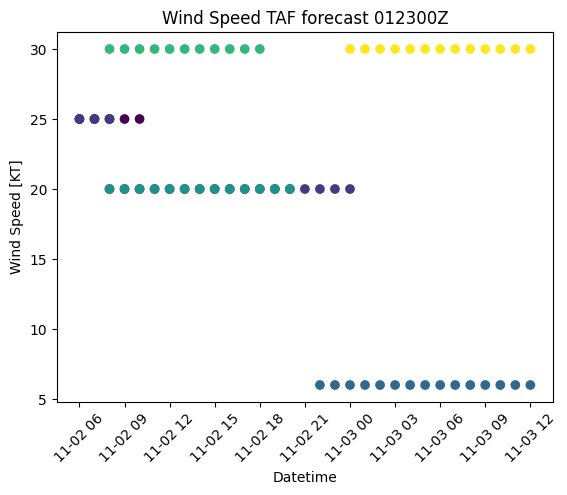

In [4]:
#visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
df['spd'] = pd.to_numeric(df['spd'], errors='coerce')
# Make sure 'st_date' and 'end_date' columns are in datetime format
df['st_date'] = pd.to_datetime(df['st_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

# Create a new DataFrame to store hourly data
hourly_data = pd.DataFrame(columns=['datetime', 'spd', 'color'])

# Iterate over each row in the original DataFrame
for index, row in df.iterrows():
    # Generate hourly datetime range between 'st_date' and 'end_date'
    hourly_range = pd.date_range(start=row['st_date'], end=row['end_date'], freq='H')

    # Append the hourly data to the new DataFrame, skipping None values
    hourly_data = pd.concat([hourly_data, pd.DataFrame({'datetime': hourly_range, 'spd': row['spd'], 'color': index})], ignore_index=True)

# Filter out rows with None values
hourly_data = hourly_data.dropna()

# Plot the data with different colors for each row
plt.scatter(hourly_data['datetime'], hourly_data['spd'], c=hourly_data['color'], cmap='viridis')
plt.xlabel('Datetime')
plt.ylabel('Wind Speed [KT]')
plt.xticks(rotation =  45)
plt.title('Wind Speed TAF forecast 012300Z')
plt.show()

In [6]:
#plot wind speed with gust
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def plot_ws_g(df):
  # Assuming df is your DataFrame
  df['spd'] = pd.to_numeric(df['spd'], errors='coerce')
  df['Gust'] = pd.to_numeric(df['Gust'].str.replace('G', ''), errors='coerce')  # Remove 'G' and convert to numeric
  # Make sure 'st_date' and 'end_date' columns are in datetime format
  df['st_date'] = pd.to_datetime(df['st_date'])
  df['end_date'] = pd.to_datetime(df['end_date'])
  TAFtime = df['Cdate'].unique()[0]
  # Create a new DataFrame to store hourly data
  hourly_data = pd.DataFrame(columns=['datetime', 'spd', 'Gust', 'color'])

  # Iterate over each row in the original DataFrame
  for index, row in df.iterrows():
    # Generate hourly datetime range between 'st_date' and 'end_date'
    hourly_range = pd.date_range(start=row['st_date'], end=row['end_date'], freq='H')

    # Append the hourly data to the new DataFrame, skipping None values
    hourly_data = pd.concat([hourly_data, pd.DataFrame({'datetime': hourly_range, 'spd': row['spd'], 'Gust': row['Gust'], 'color': index})], ignore_index=True)

  # Filter out rows with None values
  hourly_data = hourly_data.dropna()

  # Sort the DataFrame by 'datetime' column
  hourly_data = hourly_data.sort_values(by='datetime')

  # Plot the data with different markers for 'spd' and 'Gust'
  plt.scatter(hourly_data['datetime'], hourly_data['spd'], c=hourly_data['color'], cmap='viridis', label='Wind Speed [KT]')
  plt.scatter(hourly_data['datetime'], hourly_data['Gust'], c=hourly_data['color'], cmap='viridis', marker='x', label='Gust [KT]')
  plt.xlabel('Datetime')
  plt.ylabel('Wind Speed [KT]')
  plt.xticks(rotation=45)
  plt.title(f'Wind Speed and Gust TAF forecast {TAFtime}')
  plt.savefig(f'Wind_TAF{TAFtime}.png')
  plt.savefig(f'Wind_TAF{TAFtime}.pdf')
  plt.legend()
  plt.show()


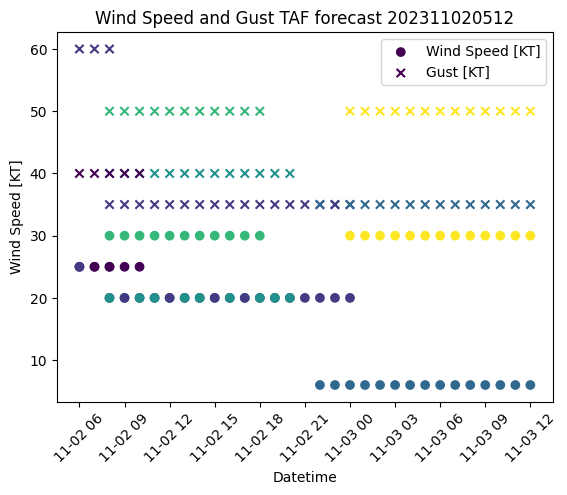

In [7]:
plot_ws_g(df)